# **Thiết lập môi trường Pyspark**

In [2]:
# Kết nối Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# !sudo apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://archive.apache.org/dist/spark/spark-3.5.4/spark-3.5.4-bin-hadoop3.tgz
!cp /content/drive/MyDrive/final_mmds/pyspark/spark-3.5.4-bin-hadoop3.tgz .
!cp /content/drive/MyDrive/final_mmds/source/task2/gold_prices.csv .
!tar xf spark-3.5.4-bin-hadoop3.tgz
!pip install -q findspark

In [4]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.4-bin-hadoop3"

In [5]:
import findspark
import pyspark as spark
findspark.init()
print(spark.__version__)

3.5.1


# **Working_path**

In [6]:
working_path = "."

# **Khởi tạo SparkSession và các thư viện cần thiết**

In [7]:
# --- PySpark Core và SQL ---
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import (
    col, to_date, year, month, dayofmonth, dayofweek,
    lag, desc, monotonically_increasing_id,
    sum as spark_sum, avg as spark_avg,
    min as spark_min, max as spark_max, count as spark_count
)
from pyspark.sql.window import Window
from pyspark.sql.types import DoubleType, DateType, StructType, StructField
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator

# --- Python Libraries ---
import pandas as pd
import shutil
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate
from typing import Tuple

# Thiết lập một số tùy chỉnh cho đồ thị
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 7)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

In [8]:
# Khởi tạo SparkSession
spark = SparkSession.builder.appName("Task2GoldPricePrediction").getOrCreate()
print("SparkSession đã được khởi tạo.")

SparkSession đã được khởi tạo.


# **Pre-process and EDA**

**Tải dữ liệu vào PySpark DataFrame và kiểm tra ban đầu**

In [9]:
# Đường dẫn đến file dữ liệu
file_path = f'{working_path}/gold_prices.csv'
# Đọc dữ liệu từ file CSV vào PySpark DataFrame
df_spark = spark.read.csv(file_path, header=True, inferSchema=True)
print(f"Tải dữ liệu từ '{file_path}' vào PySpark DataFrame thành công!")
print("\n----- Schema của DataFrame -----")
df_spark.printSchema()
print("\n----- 5 dòng dữ liệu đầu tiên -----")
df_spark.show(5)

Tải dữ liệu từ './gold_prices.csv' vào PySpark DataFrame thành công!

----- Schema của DataFrame -----
root
 |-- Date: date (nullable = true)
 |-- Buy Price: double (nullable = true)
 |-- Sell Price: double (nullable = true)


----- 5 dòng dữ liệu đầu tiên -----
+----------+---------+----------+
|      Date|Buy Price|Sell Price|
+----------+---------+----------+
|2009-08-01|    21.13|     21.19|
|2009-08-02|    21.13|     21.19|
|2009-08-03|    21.13|     21.19|
|2009-08-04|    21.13|     21.19|
|2009-08-05|    21.13|     21.19|
+----------+---------+----------+
only showing top 5 rows



**Chuyển đổi kiểu dữ liệu và chuẩn hóa tên cột**

In [10]:
print("----- Chuấn hóa tên cột -----")
# Chuyển cột 'Date' sang kiểu DateType
if dict(df_spark.dtypes)['Date'] != 'date':
    df_spark = df_spark.withColumn("Date_temp", to_date(col("Date"), "yyyy-MM-dd")) \
                        .drop("Date") \
                        .withColumnRenamed("Date_temp", "Date")
    print("Đã chuyển đổi cột 'Date' sang kiểu DateType.")

# Đổi tên cột gốc cho nhất quán (ví dụ: có khoảng trắng)
df_spark = df_spark.withColumnRenamed("Buy Price", "Buy_Price") \
                    .withColumnRenamed("Sell Price", "Sell_Price")
print("Đã đổi tên cột 'Buy Price' -> 'Buy_Price' và 'Sell Price' -> 'Sell_Price'.")

----- Chuấn hóa tên cột -----
Đã đổi tên cột 'Buy Price' -> 'Buy_Price' và 'Sell Price' -> 'Sell_Price'.


**Kiểm tra dữ liệu thiếu (Missing Values)**

In [11]:
print("----- Kiểm tra dữ liệu thiếu -----")
exprs = [spark_sum(col(c).isNull().cast("int")).alias(c) for c in ["Date", "Buy_Price", "Sell_Price"]]
missing_counts_df = df_spark.agg(*exprs)

print("Số lượng giá trị NaN mỗi cột quan trọng:")
missing_counts_df.show()

# Xử lý dữ liệu thiếu: xóa các dòng có giá trị thiếu ở các cột quan trọng
initial_count = df_spark.count()
# Chỉ xóa nếu một trong các cột Date, Buy_Price, Sell_Price bị thiếu
df_spark = df_spark.na.drop(subset=["Date", "Buy_Price", "Sell_Price"])

count_after_drop = df_spark.count()
if initial_count > count_after_drop:
    print(f"Đã xóa {initial_count - count_after_drop} dòng có giá trị thiếu ở cột Date, Buy_Price hoặc Sell_Price.")
else:
    print("Không có dòng nào bị xóa do thiếu giá trị ở Date, Buy_Price hoặc Sell_Price.")

----- Kiểm tra dữ liệu thiếu -----
Số lượng giá trị NaN mỗi cột quan trọng:
+----+---------+----------+
|Date|Buy_Price|Sell_Price|
+----+---------+----------+
|   0|        0|         0|
+----+---------+----------+

Không có dòng nào bị xóa do thiếu giá trị ở Date, Buy_Price hoặc Sell_Price.


**Kiểm tra và xử lý dữ liệu trùng lặp**

In [12]:
if df_spark is not None:
    print("----- Kiểm tra và xử lý dữ liệu trùng lặp -----")
    initial_row_count = df_spark.count()

    # Xóa các dòng trùng lặp hoàn toàn dựa trên tất cả các cột hiện có
    df_spark_no_duplicates = df_spark.dropDuplicates()

    final_row_count = df_spark_no_duplicates.count()
    num_duplicates_removed = initial_row_count - final_row_count

    if num_duplicates_removed > 0:
        print(f"Đã tìm thấy và xóa {num_duplicates_removed} dòng bị trùng lặp.")
        df_spark = df_spark_no_duplicates
    else:
        print("Không tìm thấy dòng nào bị trùng lặp hoàn toàn.")

    print(f"Số dòng hiện tại: {df_spark.count()}")
else:
    print("DataFrame 'df_spark' không tồn tại.")

----- Kiểm tra và xử lý dữ liệu trùng lặp -----
Không tìm thấy dòng nào bị trùng lặp hoàn toàn.
Số dòng hiện tại: 5565


**Thống kê mô tả**

In [13]:
print("----- Thống kê mô tả cho Buy_Price và Sell_Price -----")
columns_to_describe = ["Buy_Price", "Sell_Price"]
df_spark.select(columns_to_describe).describe().show()

----- Thống kê mô tả cho Buy_Price và Sell_Price -----
+-------+------------------+------------------+
|summary|         Buy_Price|        Sell_Price|
+-------+------------------+------------------+
|  count|              5565|              5565|
|   mean|  45.5656999101527|46.017667565139305|
| stddev|14.892834946578136|15.353833530564659|
|    min|             21.13|             21.19|
|    max|              89.0|              91.3|
+-------+------------------+------------------+



**Phân tích Phân phối của Buy_Price, Sell_Price**

----- Phân tích Phân phối của Giá Mua, Giá Bán -----


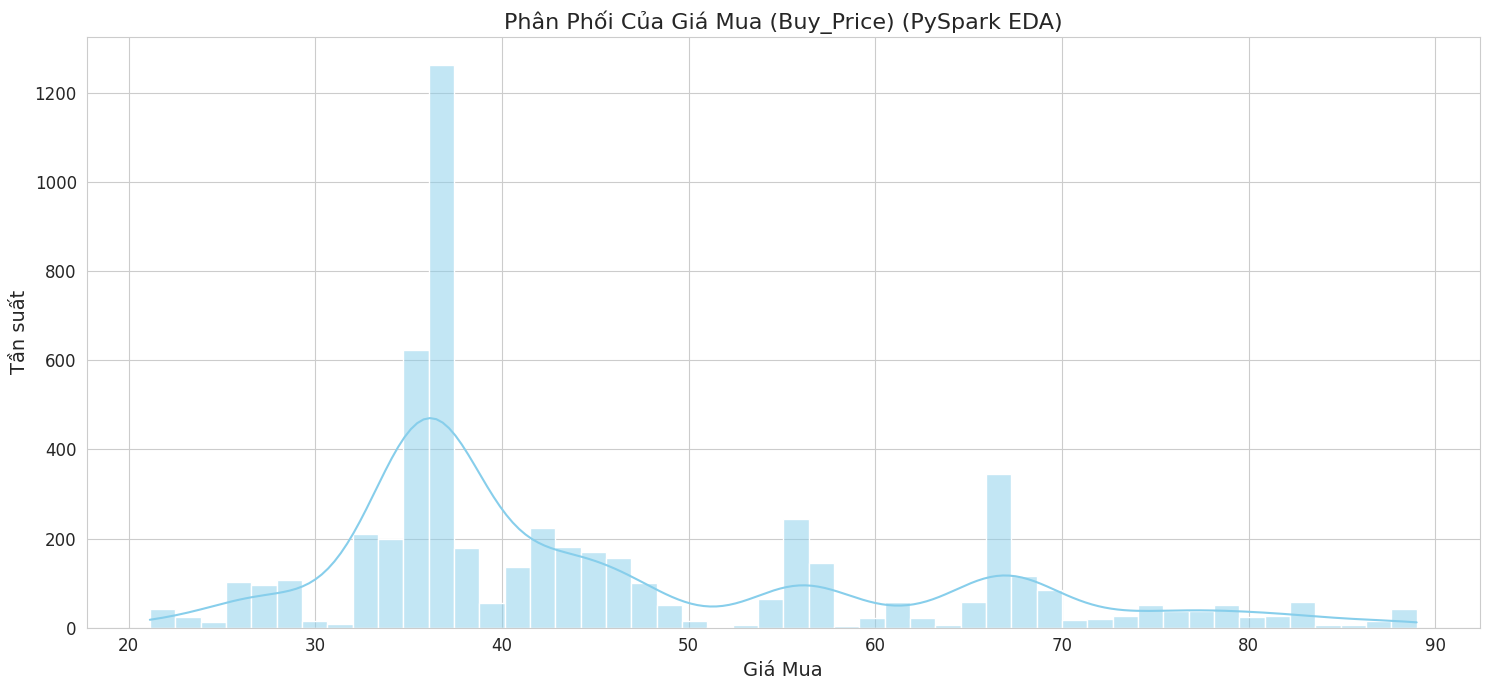

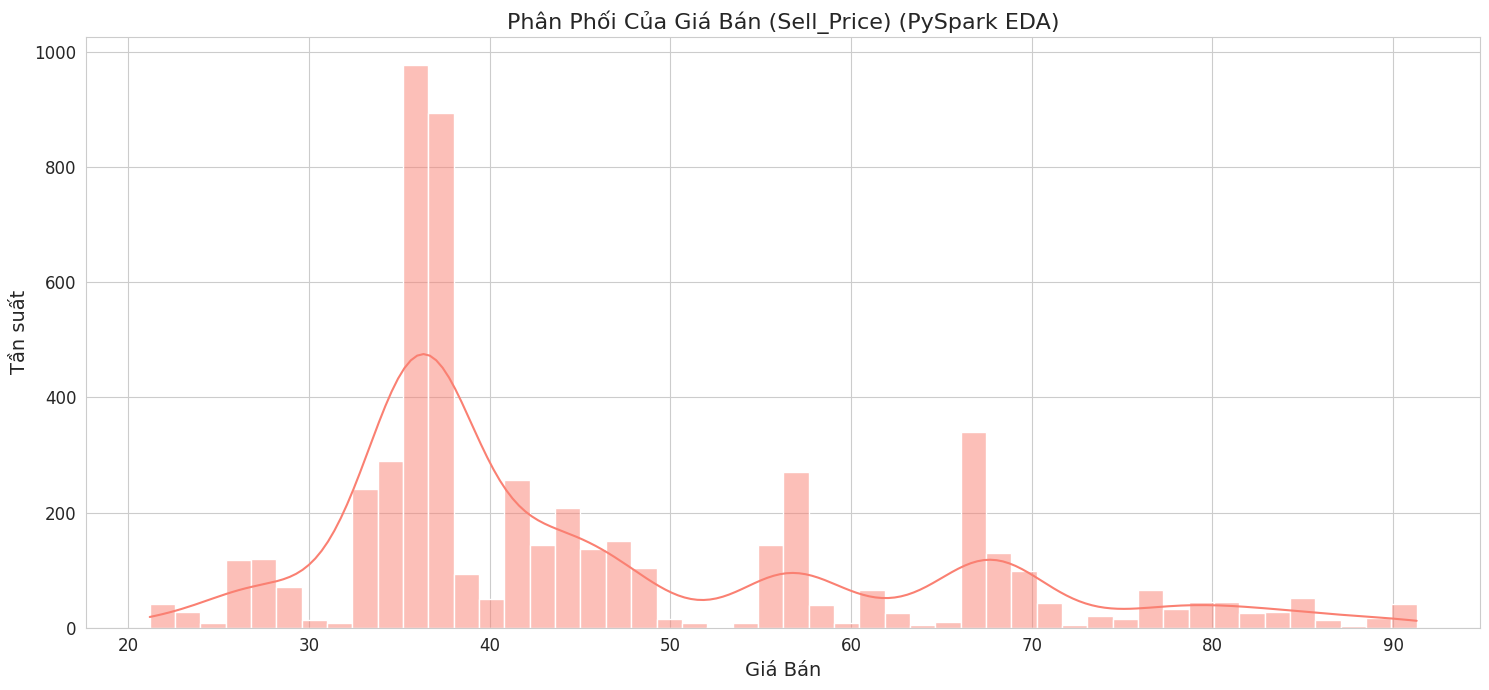

In [14]:
print("----- Phân tích Phân phối của Giá Mua, Giá Bán -----")
# Phân phối Giá Mua
buy_price_dist_pandas = df_spark.select("Buy_Price").na.drop().toPandas()
plt.figure()
sns.histplot(buy_price_dist_pandas['Buy_Price'], kde=True, color='skyblue', bins=50)
plt.title('Phân Phối Của Giá Mua (Buy_Price) (PySpark EDA)')
plt.xlabel('Giá Mua')
plt.ylabel('Tần suất')
plt.tight_layout()
plt.show()

# Phân phối Giá Bán
sell_price_dist_pandas = df_spark.select("Sell_Price").na.drop().toPandas()
plt.figure()
sns.histplot(sell_price_dist_pandas['Sell_Price'], kde=True, color='salmon', bins=50)
plt.title('Phân Phối Của Giá Bán (Sell_Price) (PySpark EDA)')
plt.xlabel('Giá Bán')
plt.ylabel('Tần suất')
plt.tight_layout()
plt.show()

**Trực quan hóa Biến động Giá Mua và Bán theo Thời gian**

----- Trực quan hóa Biến động Giá Mua và Bán theo Thời gian -----


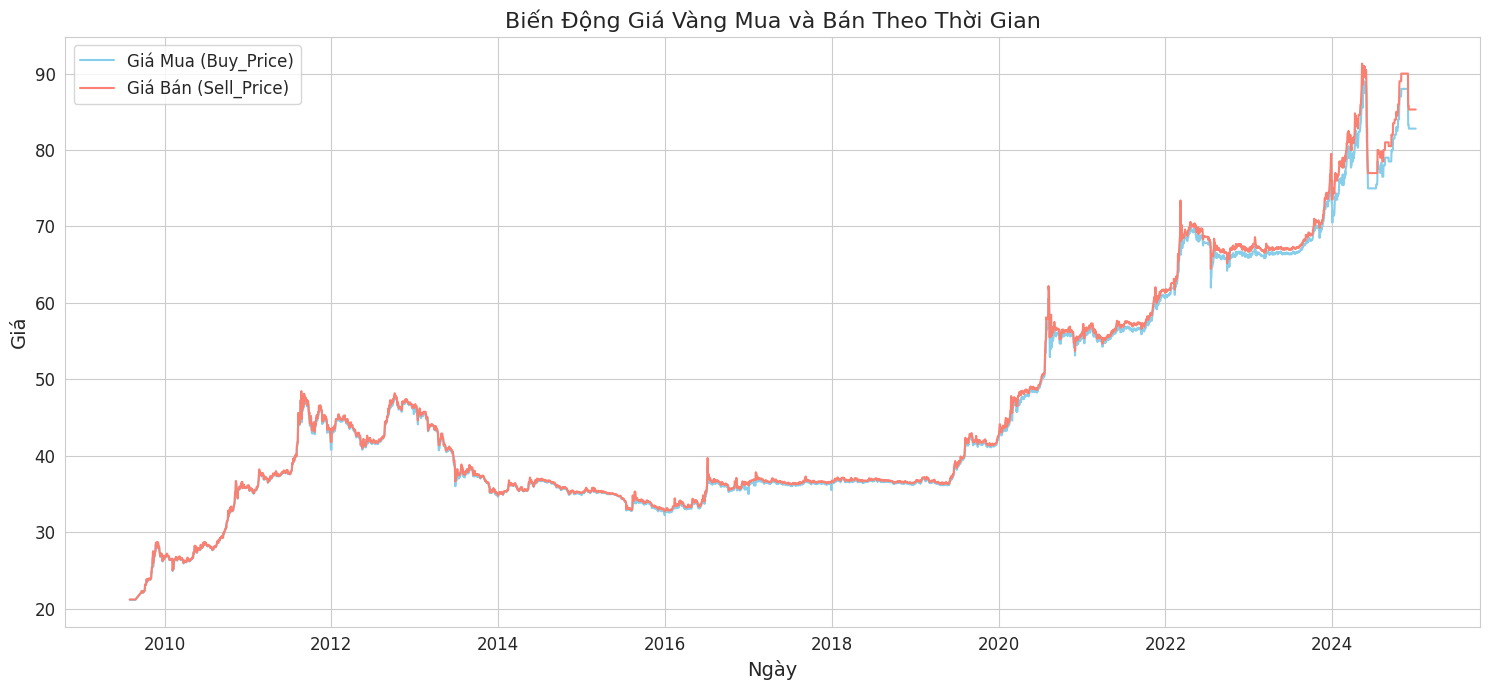

In [15]:
print("----- Trực quan hóa Biến động Giá Mua và Bán theo Thời gian -----")
plot_df_pandas = df_spark.select("Date", "Buy_Price", "Sell_Price") \
                          .orderBy("Date") \
                          .toPandas()
plt.figure()
plt.plot(plot_df_pandas['Date'], plot_df_pandas['Buy_Price'], label='Giá Mua (Buy_Price)', color='skyblue', linewidth=1.5)
plt.plot(plot_df_pandas['Date'], plot_df_pandas['Sell_Price'], label='Giá Bán (Sell_Price)', color='salmon', linewidth=1.5)
plt.title('Biến Động Giá Vàng Mua và Bán Theo Thời Gian')
plt.xlabel('Ngày')
plt.ylabel('Giá')
plt.legend()
plt.tight_layout()
plt.show()

**Nhận xét:** Dựa trên phân tích khám phá dữ liệu, đặc biệt là từ đồ thị biến động giá theo thời gian, chúng ta nhận thấy rằng giá vàng có tính 'ghi nhớ' (memory), nghĩa là giá quá khứ có ảnh hưởng đến giá hiện tại. Yêu cầu của bài toán là sử dụng giá của 10 ngày liên tiếp trước đó làm features để dự đoán giá của ngày hiện tại (t). Do đó, **Linear Regression** là một lựa chọn hợp lý để bắt đầu xây dựng mô hình dự đoán.

# **Task 2: Linear Regression – Gold price prediction**

**Lớp đối tượng tạo Feature input cho Model LR**

In [16]:
class GoldPriceFeatureEngineer:
    def __init__(self, spark: SparkSession, target_col: str = 'Buy_price', max_lag: int = 10):
        """
        :param spark: SparkSession
        :param target_col: 'Sell_Price' hoặc 'Buy_Price'
        :param max_lag: số ngày trễ để tạo feature
        """
        self.spark = spark
        self.target_col = target_col
        self.max_lag = max_lag
        self.feature_cols = [f"{self.target_col}_lag_{i}" for i in range(1, self.max_lag + 1)]
        self.assembler = VectorAssembler(inputCols=self.feature_cols, outputCol="features_vector")

    def generate_features(self, df: DataFrame) -> DataFrame:
        df = df.withColumn("label", col(self.target_col))
        window_spec = Window.orderBy("Date")

        for i in range(1, self.max_lag + 1):
            lag_col = f"{self.target_col}_lag_{i}"
            df = df.withColumn(lag_col, lag(col(self.target_col), i).over(window_spec))

        df = df.na.drop(subset=self.feature_cols + ["label"])
        df = self.assembler.transform(df)

        return df.select("Date", "features_vector", "label")

    def train_test_split(self, df: DataFrame, train_ratio: float = 0.7) -> Tuple[DataFrame, DataFrame]:
        return df.randomSplit([train_ratio, 1 - train_ratio], seed=42)


**Tạo data cho model dự đoán giá mua Buy Price**

In [17]:
# Tạo đối tượng xử lý với mục tiêu là 'Buy_Price'
engineer = GoldPriceFeatureEngineer(spark, target_col="Buy_Price")

# Lấy dataframe df_spark đã được tiền xử lý
df_buy_price = engineer.generate_features(df_spark)

# Chia tập dữ liệu thành tập train và tập test
train_buy_price_df, test_buy_price_df = engineer.train_test_split(df_buy_price, train_ratio=0.7)
print("Train set:")
train_buy_price_df.show(5, truncate=False)
print("Test set:")
test_buy_price_df.show(5, truncate=False)

Train set:
+----------+-------------------------------------------------------------+-----+
|Date      |features_vector                                              |label|
+----------+-------------------------------------------------------------+-----+
|2009-08-11|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-12|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-14|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-15|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
|2009-08-16|[21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13,21.13]|21.13|
+----------+-------------------------------------------------------------+-----+
only showing top 5 rows

Test set:
+----------+-------------------------------------------------------------+-----+
|Date      |features_vector                                              |label|
+----------+---------------------------------------------------

**Tạp data để dự đoán giá bán Sell Price**

In [18]:
# Tạo đối tượng xử lý với mục tiêu là 'Buy_Price'
engineer = GoldPriceFeatureEngineer(spark, target_col="Sell_Price")

# Lấy dataframe df_spark đã được tiền xử lý
df_sell_price = engineer.generate_features(df_spark)

train_sell_price_df, test_sell_price_df = engineer.train_test_split(df_sell_price, train_ratio=0.7)
print("Train set:")
train_sell_price_df.show(5, truncate=False)
print("Test set:")
test_sell_price_df.show(5, truncate=False)


Train set:
+----------+-------------------------------------------------------------+-----+
|Date      |features_vector                                              |label|
+----------+-------------------------------------------------------------+-----+
|2009-08-11|[21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19]|21.19|
|2009-08-12|[21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19]|21.19|
|2009-08-14|[21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19]|21.19|
|2009-08-15|[21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19]|21.19|
|2009-08-16|[21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19,21.19]|21.19|
+----------+-------------------------------------------------------------+-----+
only showing top 5 rows

Test set:
+----------+-------------------------------------------------------------+-----+
|Date      |features_vector                                              |label|
+----------+---------------------------------------------------

# **Lưu dataframe dùng cho task 3**

In [19]:
# Chuyển cột features_vector thành chuỗi
df_to_save_str = df_sell_price.select(
    "Date",
    col("features_vector").cast("string").alias("features_vector"),
    "label"
)

# Các đường dẫn
temp_output_dir = f"{working_path}/task3/dataframe_task3_temp"
final_output_dir = f"{working_path}/task3/"
final_filename = "df_10d.csv"

# Xoá thư mục cũ nếu có
shutil.rmtree(temp_output_dir, ignore_errors=True)

# Lưu DataFrame (đã chuyển vector sang string)
df_to_save_str.coalesce(1).write.mode("overwrite").option("header", True).csv(temp_output_dir)

# Tìm file part-*.csv
part_file = glob.glob(os.path.join(temp_output_dir, "part-*.csv"))[0]

# Tạo thư mục đích
os.makedirs(final_output_dir, exist_ok=True)

# Đổi tên file và di chuyển
shutil.move(part_file, os.path.join(final_output_dir, final_filename))

# Xoá thư mục tạm
shutil.rmtree(temp_output_dir)

print(f"Đã lưu file CSV thành: {os.path.join(final_output_dir, final_filename)}")

Đã lưu file CSV thành: ./task3/df_10d.csv


# **Xây dựng lớp GoldPricePredictor sử dụng mô hình Linear Regression để dự đoán**

In [20]:
class GoldPricePredictor:
    def __init__(self, features_col="features_vector", label_col="label", prediction_col="prediction",
                 max_iter=100, reg_param=0.001, elastic_net_param=0.001,
                 fit_intercept=True, standardization=True, solver="auto"):
        """
        Khởi tạo mô hình dự đoán giá vàng.

        Args:
            features_col (str): Tên cột chứa vector đặc trưng.
            label_col (str): Tên cột chứa nhãn.
            prediction_col (str): Tên cột chứa giá trị dự đoán.
            max_iter (int): Số vòng lặp tối đa.
            reg_param (float): Tham số điều chuẩn.
            elastic_net_param (float): Tham số trộn Elastic Net.
            fit_intercept (bool): Có sử dụng hệ số chặn hay không.
            standardization (bool): Có chuẩn hóa features hay không.
            solver (str): Thuật toán giải.
        """
        self.features_col = features_col
        self.label_col = label_col
        self.prediction_col = prediction_col

        self.lr_estimator = LinearRegression(
            featuresCol=self.features_col,
            labelCol=self.label_col,
            predictionCol=self.prediction_col,
            maxIter=max_iter,
            regParam=reg_param,
            elasticNetParam=elastic_net_param,
            fitIntercept=fit_intercept,
            standardization=standardization,
            solver=solver
        )

        self.model = None
        self.training_summary = None
        self.objective_history = []
        self.metrics = {}
        self.feature_names_list = []
        self.target_price_display_name = "prediction"

    def set_feature_names(self, feature_names):
        self.feature_names_list = feature_names
        return self

    def set_target_price_display_name(self, name):
        self.target_price_display_name = name
        return self

    def train(self, training_data):
        if not training_data:
            print("Lỗi: training_data không được cung cấp.")
            self.model = None
            return None

        print(f"Bắt đầu huấn luyện mô hình Linear Regression ({self.target_price_display_name}) với các tham số:")
        print(f"  MaxIter: {self.lr_estimator.getMaxIter()}, RegParam: {self.lr_estimator.getRegParam()}, ElasticNetParam: {self.lr_estimator.getElasticNetParam()}")
        print(f"  FitIntercept: {self.lr_estimator.getFitIntercept()}, Standardization: {self.lr_estimator.getStandardization()}, Solver: {self.lr_estimator.getSolver()}")

        self.model = self.lr_estimator.fit(training_data)

        self.training_summary = self.model.summary
        self.objective_history = self.training_summary.objectiveHistory

        print("Hoàn thành huấn luyện mô hình.")
        self._print_coefficients()
        return self.model

    def _print_coefficients(self):
        print(f"\nIntercept (hệ số chặn): {self.model.intercept:.4f}")
        print("Coefficients (hệ số cho mỗi đặc trưng):")
        if self.feature_names_list and len(self.feature_names_list) == len(self.model.coefficients):
            for name, coef in zip(self.feature_names_list, self.model.coefficients):
                print(f"  {name}: {coef:.4f}")
        else:
            for i, coef in enumerate(self.model.coefficients):
                print(f"  Feature_{i+1}: {coef:.4f}")


    def plot_objective_history(self):
        print("\nLịch sử hàm mục tiêu (Objective History) qua các vòng lặp huấn luyện:")
        print("Iteration\tObjective Value")
        for i, obj_val in enumerate(self.objective_history, start=1):
            print(f"{i}\t\t{obj_val:.6f}")

        plt.figure(figsize=(10, 6))
        plt.plot(range(len(self.objective_history)), self.objective_history, marker='o', linestyle='-')
        plt.title(f'Lịch Sử Hàm Mục Tiêu (Losses) - {self.target_price_display_name}')
        plt.xlabel('Vòng Lặp Tối Ưu Hóa (Iteration)')
        plt.ylabel('Giá Trị Hàm Mục Tiêu')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def evaluate(self, training_data, test_data):
        if not self.model:
            print("Mô hình chưa được huấn luyện.")
            return None
        if not training_data or not test_data:
            print("Lỗi: Cần training_data và test_data để đánh giá.")
            return None

        print("\nĐánh giá mô hình...")
        predictions_train = self.model.transform(training_data)
        predictions_test = self.model.transform(test_data)

        evaluator_rmse = RegressionEvaluator(labelCol=self.label_col, predictionCol=self.prediction_col, metricName="rmse")
        evaluator_r2 = RegressionEvaluator(labelCol=self.label_col, predictionCol=self.prediction_col, metricName="r2")
        evaluator_mae = RegressionEvaluator(labelCol=self.label_col, predictionCol=self.prediction_col, metricName="mae")

        self.metrics = {
            'train_rmse': evaluator_rmse.evaluate(predictions_train),
            'train_r2': evaluator_r2.evaluate(predictions_train),
            'train_mae': evaluator_mae.evaluate(predictions_train),
            'test_rmse': evaluator_rmse.evaluate(predictions_test),
            'test_r2': evaluator_r2.evaluate(predictions_test),
            'test_mae': evaluator_mae.evaluate(predictions_test)
        }

        print(f"\nKết quả trên tập Training (dự đoán cho {self.target_price_display_name}):")
        print(f"  RMSE: {self.metrics['train_rmse']:.3f}, MAE: {self.metrics['train_mae']:.3f}, R2: {self.metrics['train_r2']:.3f}")
        print(f"\nKết quả trên tập Test (dự đoán cho {self.target_price_display_name}):")
        print(f"  RMSE: {self.metrics['test_rmse']:.3f}, MAE: {self.metrics['test_mae']:.3f}, R2: {self.metrics['test_r2']:.3f}")
        return self.metrics

    def plot_evaluation_comparison(self):
        """Vẽ biểu đồ cột so sánh các metrics trên tập training và test."""
        if not self.metrics or 'train_rmse' not in self.metrics:
            print("Chưa có metrics để vẽ. Vui lòng chạy evaluate() trước.")
            return

        metrics_names = ['RMSE', 'MAE', 'R2']
        train_values = [self.metrics.get('train_rmse', float('nan')),
                        self.metrics.get('train_mae', float('nan')),
                        self.metrics.get('train_r2', float('nan'))]
        test_values = [self.metrics.get('test_rmse', float('nan')),
                       self.metrics.get('test_mae', float('nan')),
                       self.metrics.get('test_r2', float('nan'))]

        x_indices = range(len(metrics_names))
        plt.figure(figsize=(12, 7))
        bar_width = 0.35
        rects_train = plt.bar([i - bar_width/2 for i in x_indices], train_values, bar_width, label='Training Set', color='deepskyblue')
        rects_test = plt.bar([i + bar_width/2 for i in x_indices], test_values, bar_width, label='Test Set', color='lightcoral')

        plt.ylabel('Giá trị Metric')
        plt.title(f'So Sánh Kết Quả Đánh Giá Mô Hình ({self.target_price_display_name})')
        plt.xticks(x_indices, metrics_names)
        plt.legend()

        def add_labels(rects):
            for rect in rects:
                height = rect.get_height()
                if not pd.isna(height):
                    plt.text(rect.get_x() + rect.get_width()/2., height, f'{height:.3f}', ha='center', va='bottom')
        add_labels(rects_train)
        add_labels(rects_test)
        plt.tight_layout()
        plt.show()

    def predict(self, data_with_features):
        """
        Đưa ra dự đoán trên dữ liệu mới (đã được assembled thành features_vector).
        Args:
            data_with_features (DataFrame): PySpark DataFrame chứa cột features_col.
        Returns:
            DataFrame: DataFrame với cột predictionCol được thêm vào.
        """
        if not self.model:
            print("Mô hình chưa được huấn luyện. Không thể dự đoán.")
            return None
        if self.features_col not in data_with_features.columns:
            print(f"Lỗi: Dữ liệu mới không có cột feature '{self.features_col}'.")
            return None

        print("Đưa ra dự đoán trên dữ liệu mới...")
        predictions = self.model.transform(data_with_features)
        return predictions

# **Thực nghiệm**

Bắt đầu huấn luyện mô hình Linear Regression (Buy_Price) với các tham số:
  MaxIter: 200, RegParam: 0.01, ElasticNetParam: 0.01
  FitIntercept: True, Standardization: True, Solver: auto
Hoàn thành huấn luyện mô hình.

Intercept (hệ số chặn): 0.0184
Coefficients (hệ số cho mỗi đặc trưng):
  Buy_Price_lag_1: 0.4836
  Buy_Price_lag_2: 0.2885
  Buy_Price_lag_3: 0.1103
  Buy_Price_lag_4: 0.1034
  Buy_Price_lag_5: 0.0833
  Buy_Price_lag_6: 0.0228
  Buy_Price_lag_7: -0.0038
  Buy_Price_lag_8: -0.0304
  Buy_Price_lag_9: -0.0292
  Buy_Price_lag_10: -0.0286

Đánh giá mô hình...

Kết quả trên tập Training (dự đoán cho Buy_Price):
  RMSE: 0.372, MAE: 0.177, R2: 0.999

Kết quả trên tập Test (dự đoán cho Buy_Price):
  RMSE: 0.340, MAE: 0.160, R2: 0.999

Lịch sử hàm mục tiêu (Objective History) qua các vòng lặp huấn luyện:
Iteration	Objective Value
1		0.500000
2		0.354596
3		0.089406
4		0.023108
5		0.001008
6		0.000908
7		0.000472
8		0.000469
9		0.000468
10		0.000468
11		0.000467
12		0.000467
13		0.0

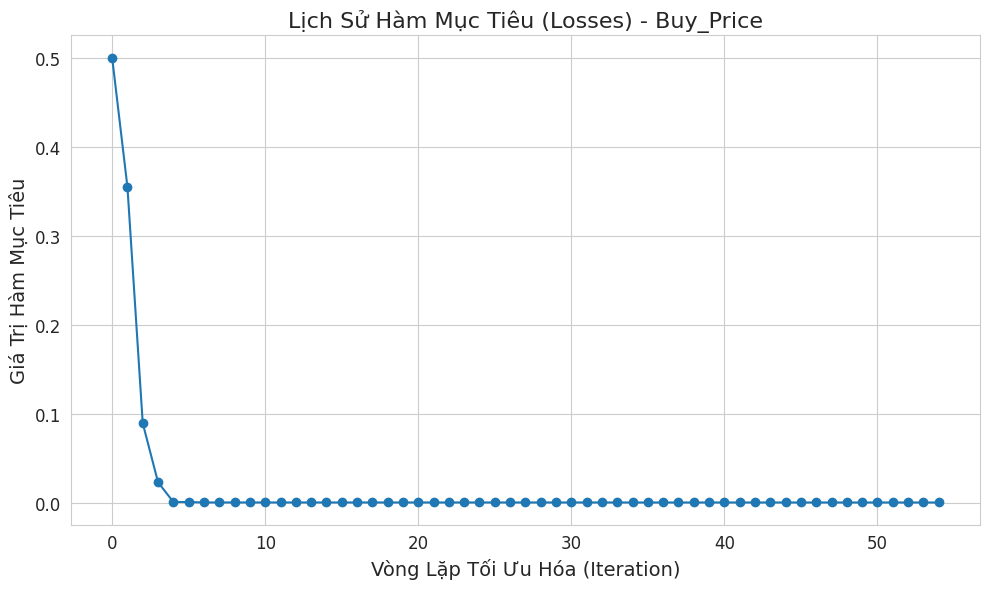

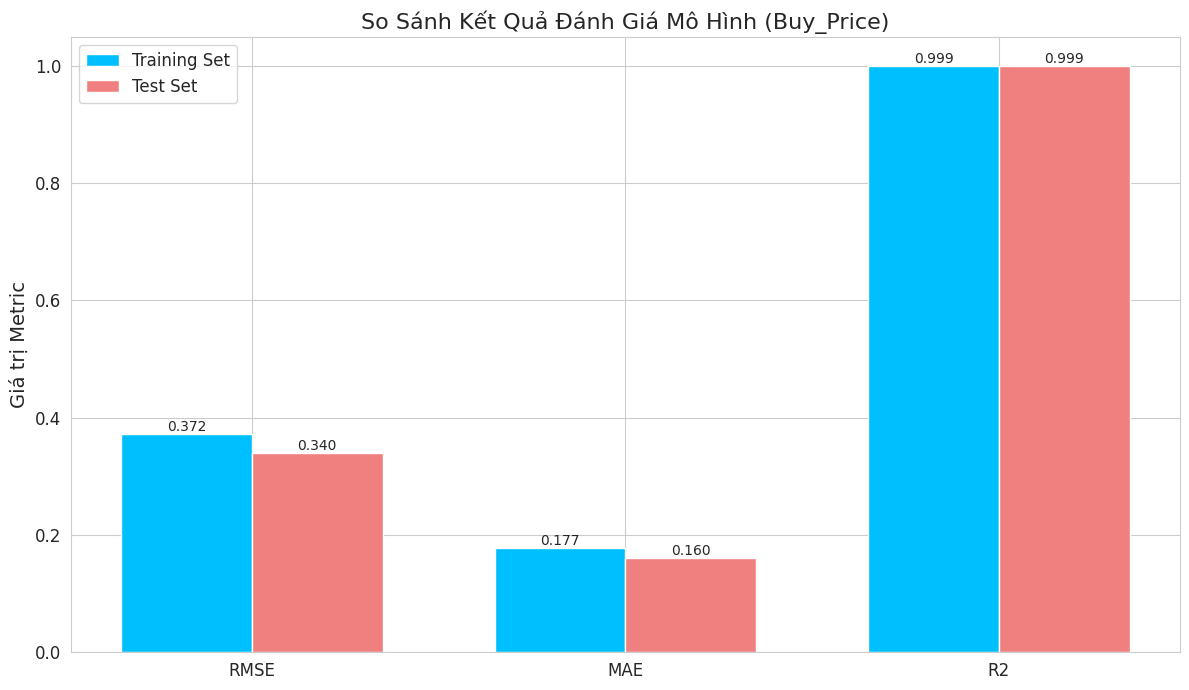

Đưa ra dự đoán trên dữ liệu mới...
+----------+-----+------------------+
|Date      |label|prediction        |
+----------+-----+------------------+
|2009-08-13|21.13|21.146874697492265|
|2009-08-17|21.13|21.146874697492265|
|2009-08-19|21.13|21.146874697492265|
|2009-08-20|21.13|21.146874697492265|
|2009-08-24|21.13|21.146874697492265|
|2009-08-25|21.13|21.146874697492265|
|2009-08-26|21.13|21.146874697492265|
|2009-09-24|22.23|22.11851703349292 |
|2009-09-26|22.04|22.23719062315412 |
|2009-09-28|22.07|22.183090407276953|
+----------+-----+------------------+
only showing top 10 rows



In [25]:
# Danh sách tên các feature columns
buy_feature_names = [f"Buy_Price_lag_{i}" for i in range(1, 11)]

# Tạo và cấu hình mô hình
buy_predictor = GoldPricePredictor(
    features_col="features_vector",
    label_col="label",
    prediction_col="prediction",
    max_iter=200,
    reg_param=0.01,
    elastic_net_param=0.01
)

buy_predictor.set_feature_names(buy_feature_names)
buy_predictor.set_target_price_display_name("Buy_Price")

# Huấn luyện mô hình
buy_predictor.train(train_buy_price_df)

# Đánh giá mô hình
buy_predictor.evaluate(train_buy_price_df, test_buy_price_df)

# Vẽ lịch sử hàm mất mát và kết quả đánh giá
buy_predictor.plot_objective_history()
buy_predictor.plot_evaluation_comparison()

# Dự đoán
buy_predictions = buy_predictor.predict(test_buy_price_df)
buy_predictions.select("Date", "label", "prediction").show(10, truncate=False)


Bắt đầu huấn luyện mô hình Linear Regression (Sell_Price) với các tham số:
  MaxIter: 200, RegParam: 0.01, ElasticNetParam: 0.01
  FitIntercept: True, Standardization: True, Solver: auto
Hoàn thành huấn luyện mô hình.

Intercept (hệ số chặn): 0.0209
Coefficients (hệ số cho mỗi đặc trưng):
  Sell_Price_lag_1: 0.5257
  Sell_Price_lag_2: 0.1662
  Sell_Price_lag_3: 0.1363
  Sell_Price_lag_4: 0.1128
  Sell_Price_lag_5: 0.0956
  Sell_Price_lag_6: 0.0685
  Sell_Price_lag_7: 0.0264
  Sell_Price_lag_8: 0.0021
  Sell_Price_lag_9: -0.0426
  Sell_Price_lag_10: -0.0911

Đánh giá mô hình...

Kết quả trên tập Training (dự đoán cho Sell_Price):
  RMSE: 0.369, MAE: 0.181, R2: 0.999

Kết quả trên tập Test (dự đoán cho Sell_Price):
  RMSE: 0.331, MAE: 0.162, R2: 1.000

Lịch sử hàm mục tiêu (Objective History) qua các vòng lặp huấn luyện:
Iteration	Objective Value
1		0.500000
2		0.354581
3		0.089353
4		0.023046
5		0.000943
6		0.000763
7		0.000760
8		0.000758
9		0.000750
10		0.000748
11		0.000740
12		0.000

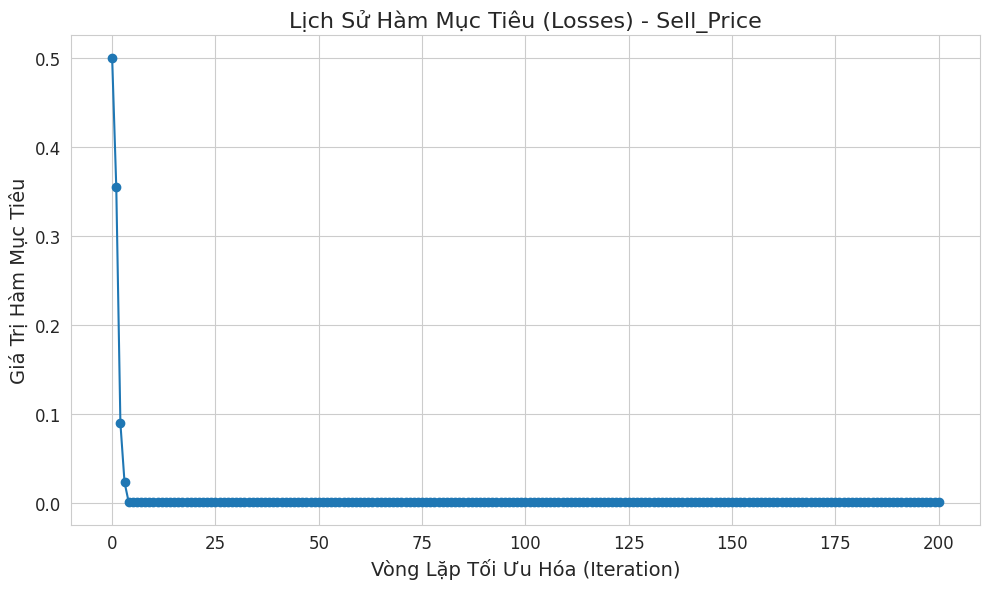

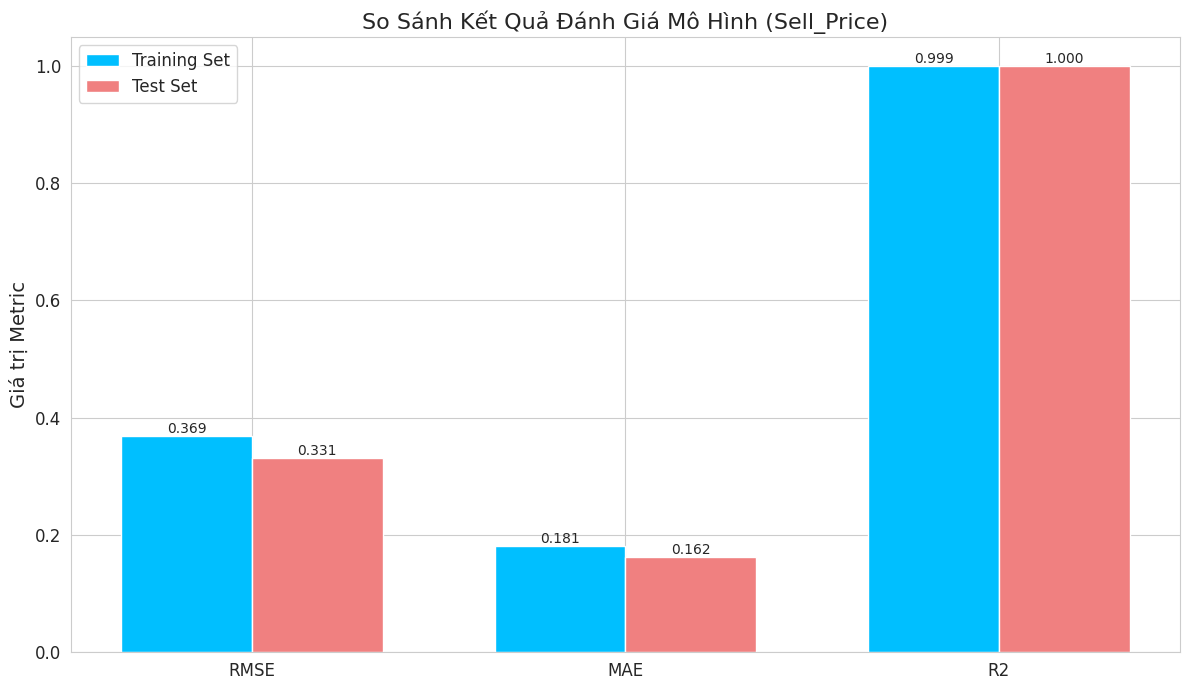

Đưa ra dự đoán trên dữ liệu mới...
+----------+-----+------------------+
|Date      |label|prediction        |
+----------+-----+------------------+
|2009-08-13|21.19|21.20857310469744 |
|2009-08-17|21.19|21.20857310469744 |
|2009-08-19|21.19|21.20857310469744 |
|2009-08-20|21.19|21.20857310469744 |
|2009-08-24|21.19|21.20857310469744 |
|2009-08-25|21.19|21.20857310469744 |
|2009-08-26|21.19|21.20857310469744 |
|2009-09-24|22.28|22.11333202484379 |
|2009-09-26|22.09|22.251786082887943|
|2009-09-28|22.12|22.290231197133995|
+----------+-----+------------------+
only showing top 10 rows



In [24]:
# Danh sách tên các feature columns
sell_feature_names = [f"Sell_Price_lag_{i}" for i in range(1, 11)]

# Tạo và cấu hình mô hình
sell_predictor = GoldPricePredictor(
    features_col="features_vector",
    label_col="label",
    prediction_col="prediction",
    max_iter=200,
    reg_param=0.01,
    elastic_net_param=0.01
)

sell_predictor.set_feature_names(sell_feature_names)
sell_predictor.set_target_price_display_name("Sell_Price")

# Huấn luyện mô hình
sell_predictor.train(train_sell_price_df)

# Đánh giá mô hình
sell_predictor.evaluate(train_sell_price_df, test_sell_price_df)

# Vẽ lịch sử hàm mất mát và kết quả đánh giá
sell_predictor.plot_objective_history()
sell_predictor.plot_evaluation_comparison()

# Dự đoán
sell_predictions = sell_predictor.predict(test_sell_price_df)
sell_predictions.select("Date", "label", "prediction").show(10, truncate=False)


**Nhận xét:**
* **Hiệu suất rất tốt:** Với các chỉ số RMSE, MAE đều thấp và R² gần bằng 1, mô hình của bạn có thể dự đoán chính xác và mạnh mẽ cho giá bán của vàng trên cả tập huấn luyện và kiểm tra.

* **Chưa có dấu hiệu overfitting:** Vì R² trên tập kiểm tra gần bằng R² trên tập huấn luyện, điều này cho thấy mô hình của bạn không bị overfitting (không học quá kỹ các chi tiết của dữ liệu huấn luyện mà làm giảm khả năng tổng quát).

# **Dự đoán giá vàng bán ra vào ngày 11/05/2025**
* Giá vàng từ ngày 01/05/2025 đến ngày 10/05/2025:
[117.0, 116.0, 116.0, 116.0, 115.4 , 118.0, 118.1, 117.2, 116.6, 116.6]

* Giá thực tế ngày 11/05/2025: [116.6]

Nguồn: Giá vàng PNJ TPHCM từ https://bieudogiavang.net/

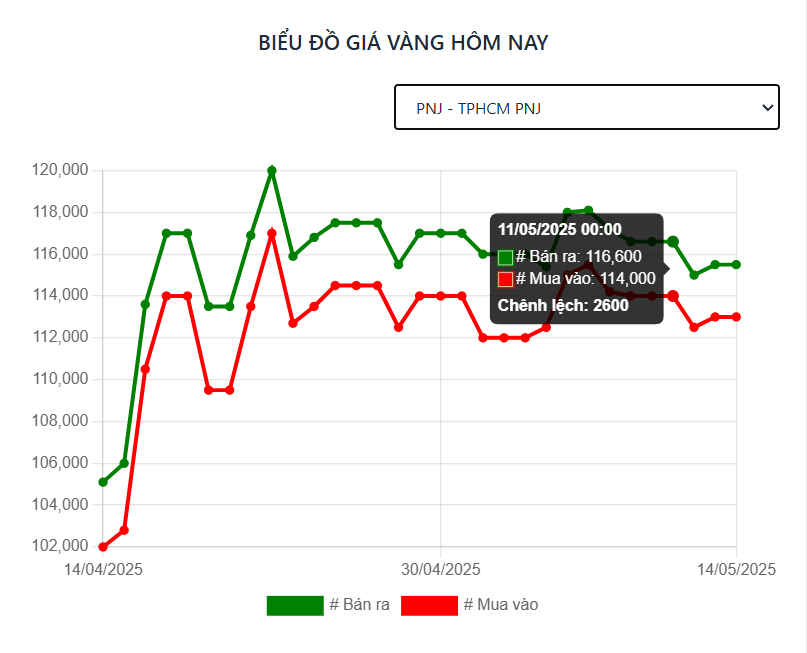

In [27]:
historical_prices_raw = [117.0, 116.0, 116.0, 116.0, 115.4 , 118.0, 118.1, 117.2, 116.6, 116.6]
actual_price_target_date = 116.6 # Giá thực tế ngày 11/05/2025

features_for_model_ordered = [
    historical_prices_raw[9], # lag_1 (10/05)
    historical_prices_raw[8], # lag_2 (09/05)
    historical_prices_raw[7], # lag_3 (08/05)
    historical_prices_raw[6], # lag_4 (07/05)
    historical_prices_raw[5], # lag_5 (06/05)
    historical_prices_raw[4], # lag_6 (05/05)
    historical_prices_raw[3], # lag_7 (04/05)
    historical_prices_raw[2], # lag_8 (03/05)
    historical_prices_raw[1], # lag_9 (02/05)
    historical_prices_raw[0]  # lag_10 (01/05)
]

# Tạo schema động dựa trên feature_cols_generated_names
schema_fields = [StructField(col_name, DoubleType(), True) for col_name in sell_feature_names]
new_data_schema = StructType(schema_fields)
new_data_row = [tuple(features_for_model_ordered)]

df_new_point_features = spark.createDataFrame(new_data_row, schema=new_data_schema)

# Sử dụng VectorAssembler
assembler_for_prediction = VectorAssembler(
    inputCols=sell_feature_names,
    outputCol=sell_predictor.features_col
)
df_new_point_assembled = assembler_for_prediction.transform(df_new_point_features)

# Gọi phương thức predict
predicted_df = sell_predictor.predict(df_new_point_assembled)

# Hiển thị kết quả
predicted_value = predicted_df.select(sell_predictor.prediction_col).first()[0]
print(f"Giá {sell_predictor.target_price_display_name} dự đoán cho ngày 11/05/2025: {predicted_value:.3f}")
print(f"Giá thực tế ngày 11/05/2025: {actual_price_target_date}")
print(f"Chênh lệch dự đoán: {abs(predicted_value - actual_price_target_date):.3f}")

Đưa ra dự đoán trên dữ liệu mới...
Giá Sell_Price dự đoán cho ngày 11/05/2025: 116.883
Giá thực tế ngày 11/05/2025: 116.6
Chênh lệch dự đoán: 0.283


**Dừng SparkSession**

In [ ]:
# Dừng SparkSession khi bạn đã hoàn thành tất cả các bước
spark.stop()
print("SparkSession đã được dừng.")